# Auto ML : Catboost vs PyCaret vs Lazy Predict

## 1. Setting

본 테스트에 앞서 공통된 데이터로 Kaggle의 [성인 인구조사 소득 예측 대회] 데이터셋을 사용합니다.

<br /><br />
본 데이터 셋은 1994년 미국 성인을 대상으로 소득 관련 인구조사를 시행한 데이터로

해당 인구조사 항목을 활용하여 각 사람의 소득을 예측하는 것을 목적으로 한다.

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# numpy 추가 설정
np.random.seed(2024)
np.set_printoptions(precision = 4, suppress = True)

# pandas 추가 설정
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
# pd.options.display.max_rows = 20
# pd.options.display.max_columns = 20
# pd.options.display.max_colwidth = 80

# matplotlib 크기, 테마 설정
plt.rc("figure", figsize = (8, 4))
colors = sns.color_palette('husl')

# seaborn 추가 설정
sns.set_theme( style="white" )

# 그래프 폰트 깨짐 방지
import matplotlib.font_manager as fm
import os
import matplotlib.pyplot as plt
!apt -qq install fonts-nanum
fe = fm.FontEntry(
    fname = r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name = 'NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 12, 'font.family': 'NanumGothic'})

# 경고메세지 무시
import warnings
warnings.filterwarnings("ignore")

fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [143]:
# Data Load
train_raw = pd.read_csv("/content/drive/MyDrive/Dataset/People_income/train.csv")
test_raw = pd.read_csv("/content/drive/MyDrive/Dataset/People_income/test.csv")
submission_raw = pd.read_csv("/content/drive/MyDrive/Dataset/People_income/sample_submission.csv")

# Data engineering 을 위한 Data Copy
train = train_raw.copy()
test = test_raw.copy()

## 2. EDA

### 2.1 Columns Check

- train : 16 cloumns (income 포함), 결측치 없음
- test : 15 cloumns, 결측치 없음

In [144]:
train.head()

,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,0,40,Private,168538,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States,>50K
1,1,17,Private,101626,9th,5,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,20,United-States,<=50K
2,2,18,Private,353358,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,16,United-States,<=50K
3,3,21,Private,151158,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,25,United-States,<=50K
4,4,24,Private,122234,Some-college,10,Never-married,Adm-clerical,Not-in-family,Black,Female,0,0,20,?,<=50K


In [145]:
test.head()

,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,0,28,Private,67661,Some-college,10,Never-married,Adm-clerical,Other-relative,White,Female,0,0,40,United-States
1,1,40,Self-emp-inc,37869,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States
2,2,20,Private,109952,Some-college,10,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,25,United-States
3,3,40,Private,114537,Assoc-voc,11,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States
4,4,37,Private,51264,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,99,France


In [146]:
train.shape, test.shape

((26049, 16), (6512, 15))

In [147]:
print(train.info())

print("-" * 100)

print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26049 entries, 0 to 26048
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              26049 non-null  int64 
 1   age             26049 non-null  int64 
 2   workclass       26049 non-null  object
 3   fnlwgt          26049 non-null  int64 
 4   education       26049 non-null  object
 5   education_num   26049 non-null  int64 
 6   marital_status  26049 non-null  object
 7   occupation      26049 non-null  object
 8   relationship    26049 non-null  object
 9   race            26049 non-null  object
 10  sex             26049 non-null  object
 11  capital_gain    26049 non-null  int64 
 12  capital_loss    26049 non-null  int64 
 13  hours_per_week  26049 non-null  int64 
 14  native_country  26049 non-null  object
 15  income          26049 non-null  object
dtypes: int64(7), object(9)
memory usage: 3.2+ MB
None
--------------------------------------------

In [ ]:
train.describe(include='O')

### 2.2 결측치, 이상치 Check

위 과정에서 데이터 타입과 칼럼 구성을 알아보았습니다.

그렇다면 결측치, 이상치의 존재여부를 조사하기 위해 각 칼럼의 값들을 탐색하였습니다.

In [148]:
num_null = train.isnull().sum()
percent = (train.isnull().sum() / train.isnull().count() * 100)

pd.concat([num_null, percent], axis=1, keys=['num_null', 'percent']).sort_values(by='percent', ascending=False)

,num_null,percent
id,0,0.0
age,0,0.0
workclass,0,0.0
fnlwgt,0,0.0
education,0,0.0
education_num,0,0.0
marital_status,0,0.0
occupation,0,0.0
relationship,0,0.0
race,0,0.0


In [149]:
num_null = test.isnull().sum()
percent = (test.isnull().sum() / test.isnull().count() * 100)

pd.concat([num_null, percent], axis=1, keys=['num_null', 'percent']).sort_values(by='percent', ascending=False)

,num_null,percent
id,0,0.0
age,0,0.0
workclass,0,0.0
fnlwgt,0,0.0
education,0,0.0
education_num,0,0.0
marital_status,0,0.0
occupation,0,0.0
relationship,0,0.0
race,0,0.0


눈에 띄는 이상치는 특별히 발견되지 않았으며

결측치는 없으나 "?" 값이 발견되어 어떤 칼럼에 분포하였는지 체크 후 이후 전처리를 수행하겠습니다.

In [150]:
for col in train.columns:
    if '?' in train[col].values:
        print(col)

workclass
occupation
native_country


[ Column 설명 ]

각 칼럼의 자세한 설명은 아래 Dataset의 설명서를 참고한다.

  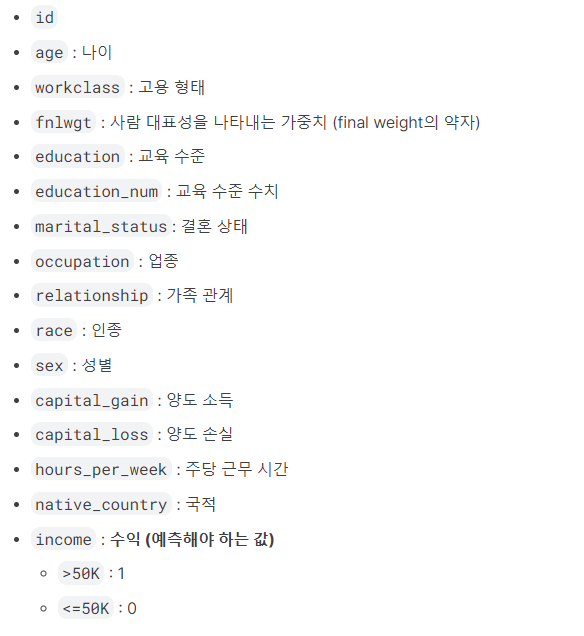

**[ EDA 요약 ]**

- 본 데이터셋은 칼럼 총 16개로 feature의 타입(type)은 int 6개, object 9개 로 구성되었습니다.
- 데이터 칼럼 별 Null 값은 없으나 몇몇 칼럼에 "?" 값이 보여 데이터 전처리 필요할 것으로 판단됩니다.
- 각각 칼럼의 특성을 고려하여 아래 기재된 순서대로 전처리 및 시각화 작업을 진행합니다.
- 각 칼럼 중 전문 용어로 구성된 칼럼은 해당 칼럼 분석에 부가 설명을 표기하였습니다.

<br /><br />
아래 전처리 순서는 해당 의미가 비슷한 칼럼으로 그룹화하여 진행합니다.

1 Income (소득)

2 Age(나이)

3 Workclass(고용형태) & Occupation(업종)

4 education(교육 수준) & education_num(교육 수준 수치)

5 Marital_status(결혼 상태) & Relationship(가족 관계)

6 Race(인종) & Native_country(국적)

7 Sex(성별)

8 Hours_per_week(주당 근무 시간)

9 capital_gain(양도 소득) & capital_loss(양도 손실)

10 fnlwgt(사람 대표성 가중치)

## 3. Future Engineering

### 3.1 Income (소득)

Target 예측값인 income 칼럼이 이진분류 가능한 값으로 해당 값을 0,1 값으로 반환합니다.
- '>50K': 1
- '<=50K': 0

In [151]:
train["income"] = train["income"].map(lambda x: 0 if x == "<=50K" else 1)

train['income'].value_counts()

income
0    19744
1     6305
Name: count, dtype: int64

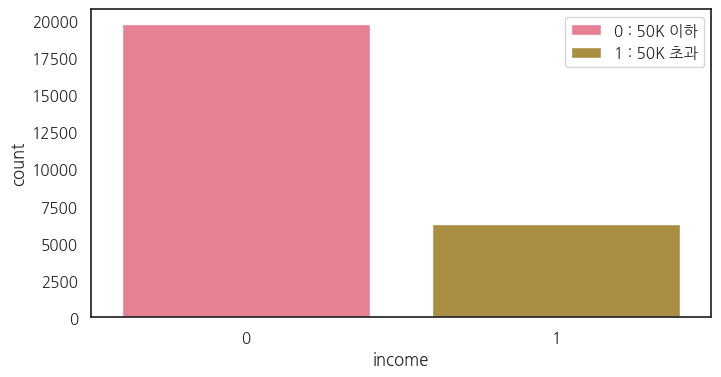

In [152]:
sns.countplot(x='income', data=train, palette = colors)

plt.legend(labels=["0 : 50K 이하","1 : 50K 초과" ])

### 3.2 Age(나이)

- 연령대 범주를 카테고리로 나누지 않고 기존 데이터 값인 연속형 변수로

  데이터를 측정하였을 때 모델 정확도에 소폭 상향 보여 기존 칼럼을 유지하여 진행합니다.

In [153]:
print('최소 연령: ', train['age'].min())
print('최고 연령: ', train['age'].max())
print('최빈 연령: ', train["age"].mode().iloc[0])
print('평균 연령: {:.2f}'.format(train['age'].mean()))

최소 연령:  17
최고 연령:  90
최빈 연령:  31
평균 연령: 38.57


In [154]:
train['age'].value_counts().sort_index()

age
17    325
18    429
19    567
20    597
21    567
     ... 
85      2
86      1
87      1
88      3
90     36
Name: count, Length: 73, dtype: int64

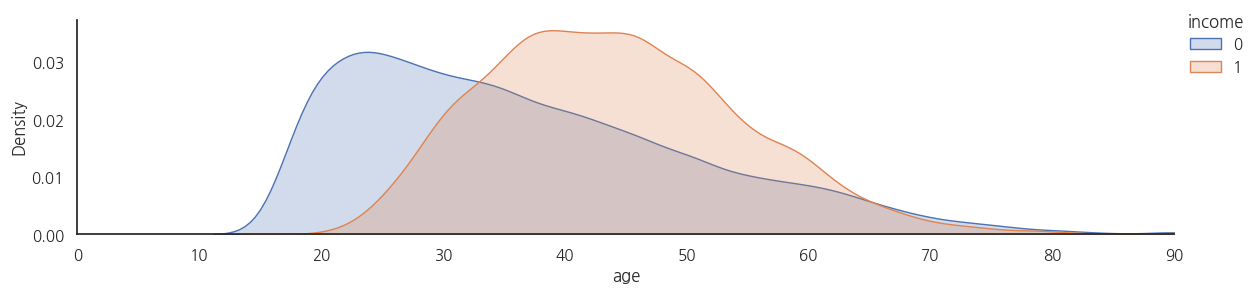

In [155]:
snake = sns.FacetGrid(train, hue="income", aspect=4)
snake.map(sns.kdeplot, "age", shade=True)
snake.set(xlim=(0, train["age"].max()))
snake.add_legend(loc='upper right')

plt.show()

### 3.3 Workclass(고용형태) & Occupation(업종)

Workclass & Occupation 칼럼에 결측치는 없으나 "?" 형태의 데이터가 각 칼럼 대략 1,500개 정도 발견되었습니다.

결측치를 최빈값으로 대체하거나 제거시 1,502 개의 데이터 변화에 의한 성능 저하를 우려하여 Drop 판단을 하기 전 조금 더 세밀히 살펴봅니다.

In [156]:
train['workclass'].value_counts()

workclass
Private             18123
Self-emp-not-inc     2030
Local-gov            1692
?                    1502
State-gov            1043
Self-emp-inc          877
Federal-gov           765
Without-pay            11
Never-worked            6
Name: count, dtype: int64

<Axes: xlabel='workclass', ylabel='count'>

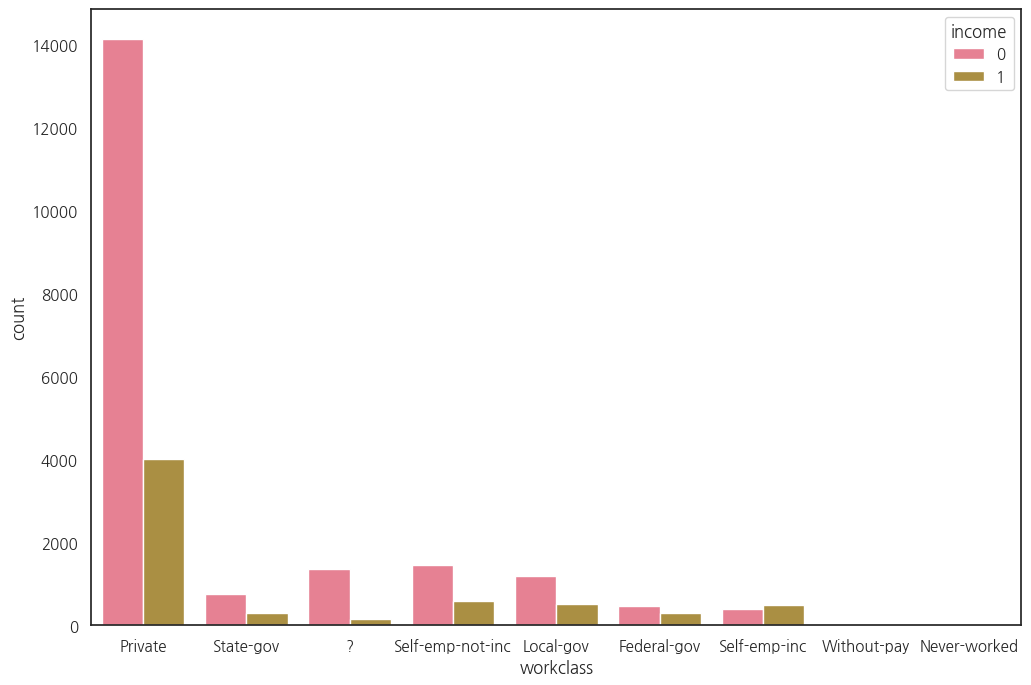

In [157]:
plt.rc("figure", figsize = (12, 8))

sns.countplot(x='workclass', hue='income', data=train, palette = colors)

In [158]:
train['occupation'].value_counts()

occupation
Prof-specialty       3304
Craft-repair         3262
Exec-managerial      3246
Sales                2998
Adm-clerical         2983
Other-service        2626
Machine-op-inspct    1582
?                    1508
Transport-moving     1270
Handlers-cleaners    1092
Farming-fishing       784
Tech-support          742
Protective-serv       522
Priv-house-serv       123
Armed-Forces            7
Name: count, dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'Sales'),
  Text(1, 0, 'Machine-op-inspct'),
  Text(2, 0, 'Other-service'),
  Text(3, 0, 'Prof-specialty'),
  Text(4, 0, 'Adm-clerical'),
  Text(5, 0, 'Craft-repair'),
  Text(6, 0, '?'),
  Text(7, 0, 'Handlers-cleaners'),
  Text(8, 0, 'Farming-fishing'),
  Text(9, 0, 'Exec-managerial'),
  Text(10, 0, 'Transport-moving'),
  Text(11, 0, 'Protective-serv'),
  Text(12, 0, 'Tech-support'),
  Text(13, 0, 'Priv-house-serv'),
  Text(14, 0, 'Armed-Forces')])

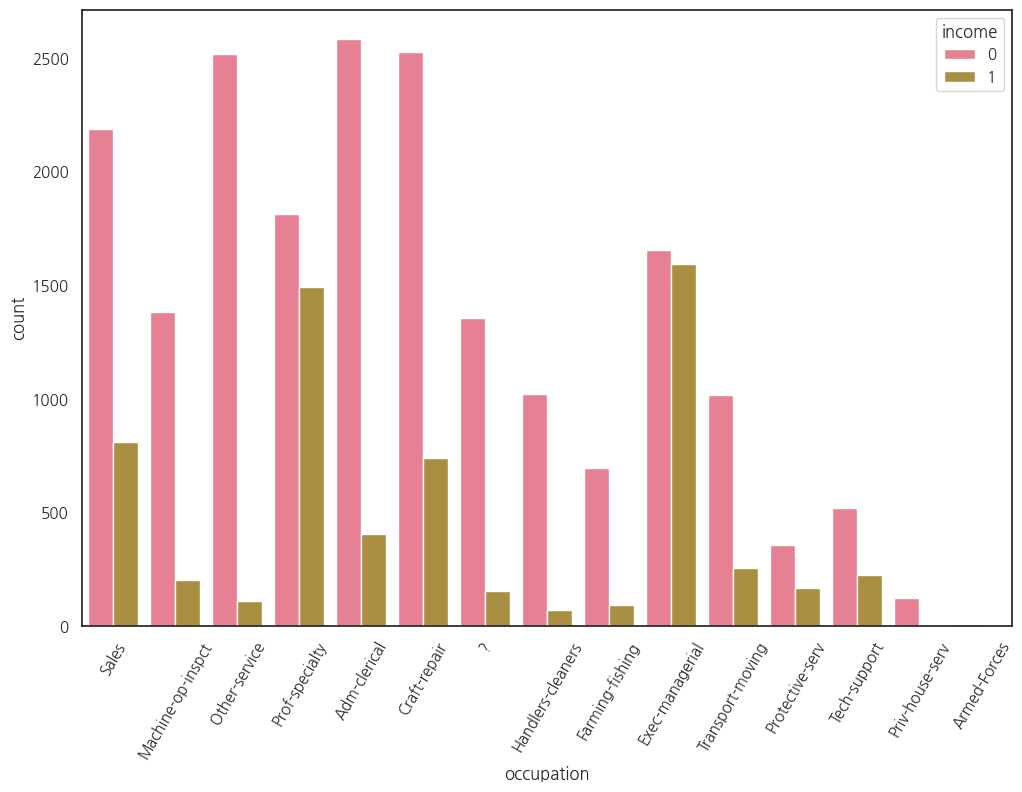

In [159]:
plt.rc("figure", figsize = (12, 8))

sns.countplot(x='occupation', hue='income', data=train, palette = colors)
plt.xticks(rotation=60)

workclass'의 "?"값과 'occupation'의 "?" 값의 크기가 비슷하여 두 칼럼이 일치하는지 확인합니다.

In [160]:
train[(train['workclass'] == '?') & (train['occupation'] == '?')].shape[0] == train[train['workclass'] == '?'].shape[0]

True

workclass는 '?'가 아니지만 occupation 만 '?'를 가지는 데이터를 확인한 결과

'Never-worked' 업종에서 추가적으로 6개의 "?" 값을 갖는 것을 확인하였습니다.

Never-worked 칼럼 값을 제외한 모든 값에서 "?" 값이 일치하였음을 확인하였습니다.

In [161]:
train[(train['workclass'] != '?') & (train['occupation'] == '?')][['workclass', 'occupation']]

,workclass,occupation
7929,Never-worked,?
8698,Never-worked,?
13008,Never-worked,?
15076,Never-worked,?
17531,Never-worked,?
24153,Never-worked,?


Never-worked 칼럼 값을 Drop 하여 총 "?"값을 workclass와 일치시킵니다.

In [162]:
train.drop(train[train['workclass'] == 'Never-worked'].index, axis=0, inplace=True)

### 3.4 education(교육 수준) & education_num(교육 수준 수치)


education(교육 수준) & education_num(교육 수준 수치)의 의미가 비슷해 데이터 값이 어떤 형태로 다른지 확인합니다.

In [163]:
train['education'].value_counts()

education
HS-grad         8433
Some-college    5798
Bachelors       4344
Masters         1378
Assoc-voc       1096
11th             921
Assoc-acdm       842
10th             729
7th-8th          504
Prof-school      466
9th              418
12th             359
Doctorate        316
5th-6th          265
1st-4th          134
Preschool         40
Name: count, dtype: int64

In [164]:
train['education_num'].value_counts()

education_num
9     8433
10    5798
13    4344
14    1378
11    1096
7      921
12     842
6      729
4      504
15     466
5      418
8      359
16     316
3      265
2      134
1       40
Name: count, dtype: int64

education(교육 수준) & education_num(교육 수준 수치)는 같은 의미를 가지므로

중복되는 칼럼인 education_num (교육 수준 수치) 칼럼을 Drop 합니다.

In [165]:
train = train.drop('education_num', axis=1)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, 'HS-grad'),
  Text(1, 0, '9th'),
  Text(2, 0, 'Some-college'),
  Text(3, 0, 'Bachelors'),
  Text(4, 0, '11th'),
  Text(5, 0, '1st-4th'),
  Text(6, 0, '5th-6th'),
  Text(7, 0, 'Assoc-acdm'),
  Text(8, 0, '10th'),
  Text(9, 0, 'Prof-school'),
  Text(10, 0, '7th-8th'),
  Text(11, 0, 'Masters'),
  Text(12, 0, 'Assoc-voc'),
  Text(13, 0, 'Doctorate'),
  Text(14, 0, '12th'),
  Text(15, 0, 'Preschool')])

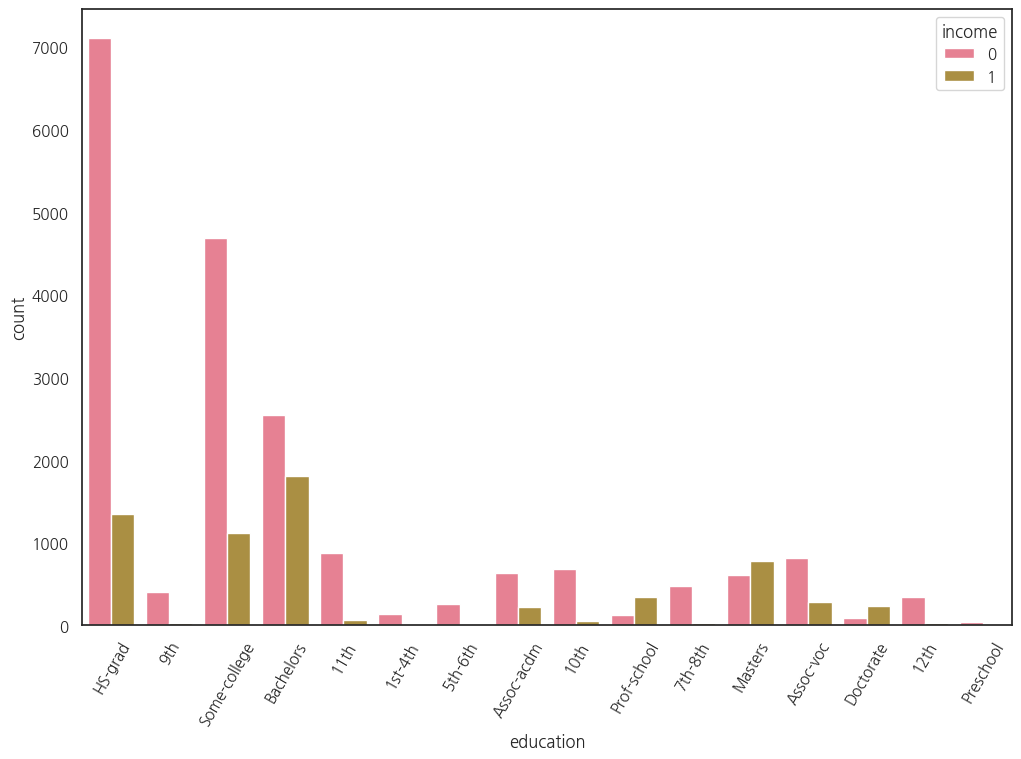

In [166]:
plt.rc("figure", figsize = (12, 8))

sns.countplot(x='education', hue='income', data=train, palette = colors)
plt.xticks(rotation=60)

### 3.5 Marital_status(결혼 상태) & Relationship(가족 관계)

Marital_status & Relationship 두 칼럼 모두 결혼에 관한 데이터를 의미한다.

두 칼럼은 비슷한 의미를 가지나 값의 분포가 상이하고 단어 해석만으로 분석을 하기에

당시 분석통계용어가 포함되어 있어 해당 데이터는 별도 전처리를 시행하지 않는다.

In [167]:
train['marital_status'].value_counts()

marital_status
Married-civ-spouse       11970
Never-married             8563
Divorced                  3535
Separated                  826
Widowed                    796
Married-spouse-absent      334
Married-AF-spouse           19
Name: count, dtype: int64

<Axes: xlabel='marital_status', ylabel='count'>

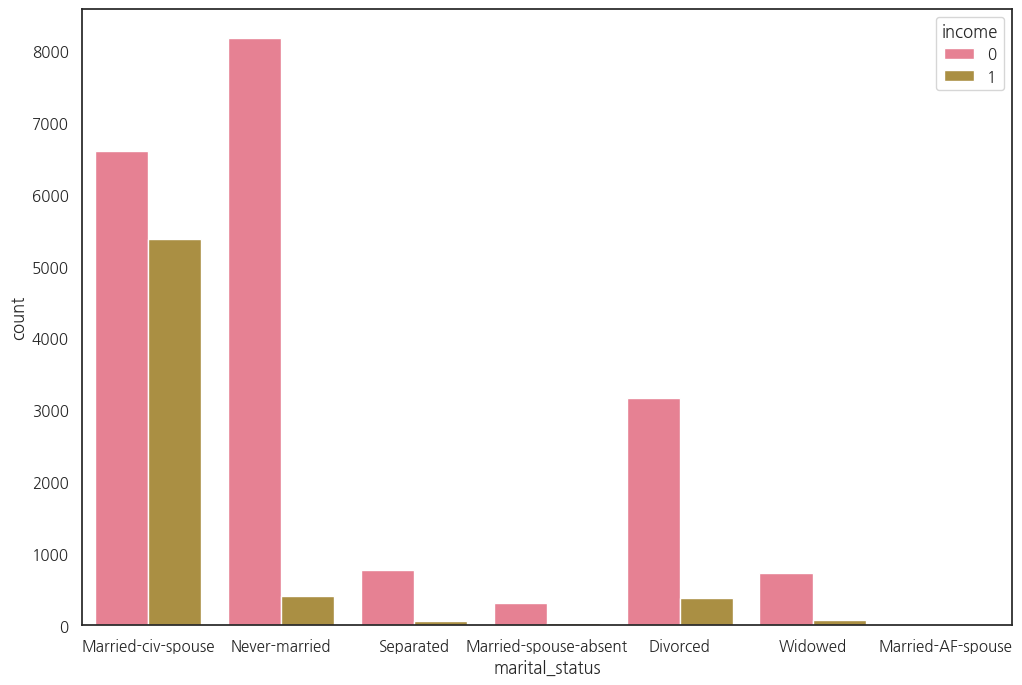

In [168]:
plt.rc("figure", figsize = (12, 8))

sns.countplot(x='marital_status', hue='income', data=train, palette = colors)

In [169]:
train['relationship'].value_counts()

relationship
Husband           10541
Not-in-family      6631
Own-child          4094
Unmarried          2740
Wife               1260
Other-relative      777
Name: count, dtype: int64

<Axes: xlabel='relationship', ylabel='count'>

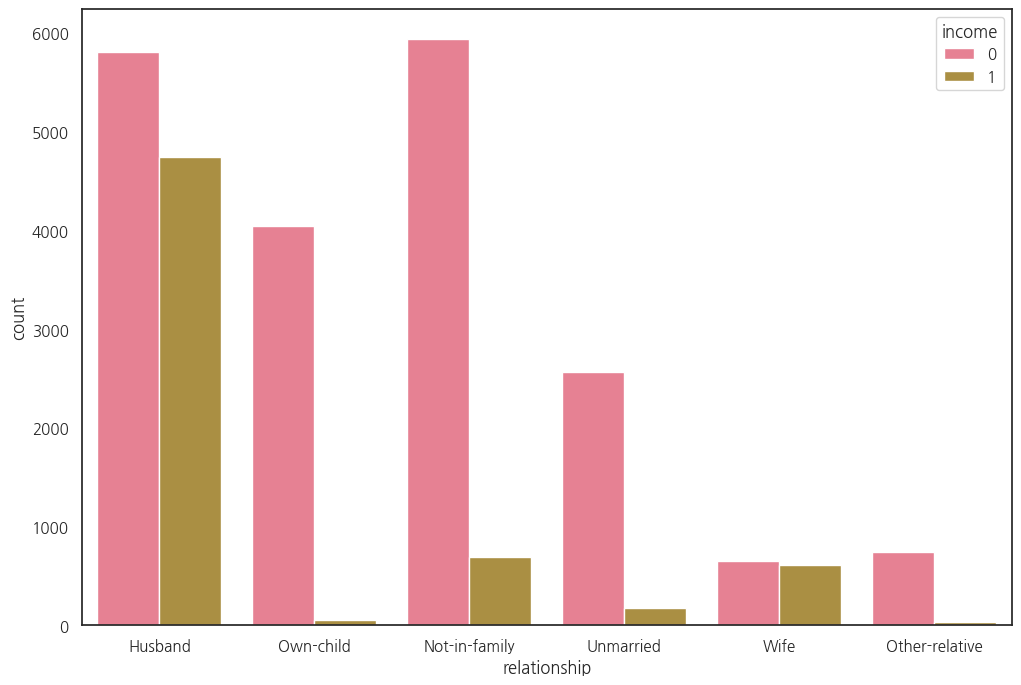

In [170]:
plt.rc("figure", figsize = (12, 8))

sns.countplot(x='relationship', hue='income', data=train, palette = colors)

### 3.6 Race(인종) & Native_country(국적)

Race(인종)의 경우 데이터에 백인이 가장 많은 분포를 보이며 값에 이상이 없음을 확인하여 전처리를 시행하지 않는다.

하지만 Native_country(국적)은 변수가 너무 많아 나라 별 대륙 별로 구분하였다.

기존 Native_country 칼럼을 Drop 한 이후 새롭게 생성한 Native_country 칼럼의 대륙을 구분한 값은 다음과 같다.

- north_america = ['United-States', 'Mexico', 'Canada', 'Puerto-Rico', 'El-Salvador', 'Cuba', 'Jamaica', 'Guatemala', 'Dominican-Republic', 'Honduras']
- europe = ['Germany', 'England', 'Italy', 'Poland', 'Portugal', 'Greece', 'Ireland', 'Scotland', 'France', 'Yugoslavia', 'Hungary']
- asia = ['Philippines', 'India', 'China', 'Japan', 'Taiwan', 'Iran', 'Vietnam', 'Hong', 'Cambodia', 'Laos', 'Thailand']
- south_america = ['South', 'Columbia', 'Peru', 'Ecuador', 'Haiti', 'Trinadad&Tobago', 'Nicaragua', 'Outlying-US(Guam-USVI-etc)']



In [171]:
train['race'].value_counts()

race
White                 22310
Black                  2475
Asian-Pac-Islander      800
Amer-Indian-Eskimo      254
Other                   204
Name: count, dtype: int64

In [172]:
train['native_country'].value_counts()

native_country
United-States                 23365
Mexico                          534
?                               456
Philippines                     163
Germany                         101
Puerto-Rico                      95
Canada                           92
El-Salvador                      79
India                            77
Cuba                             76
England                          67
Jamaica                          64
South                            63
China                            57
Guatemala                        52
Columbia                         52
Italy                            50
Vietnam                          50
Dominican-Republic               48
Poland                           47
Japan                            47
Taiwan                           39
Haiti                            35
Iran                             35
Portugal                         30
Nicaragua                        28
Peru                             26
Ecuador      

In [173]:
# 대륙별 국가 목록 / united-states 별도 생성
united_states = ['United-States']
north_america = ['Mexico', 'Canada', 'Puerto-Rico', 'El-Salvador', 'Cuba', 'Jamaica', 'Guatemala', 'Dominican-Republic', 'Honduras']
europe = ['Germany', 'England', 'Italy', 'Poland', 'Portugal', 'Greece', 'Ireland', 'Scotland', 'France', 'Yugoslavia', 'Hungary']
asia = ['Philippines', 'India', 'China', 'Japan', 'Taiwan', 'Iran', 'Vietnam', 'Hong', 'Cambodia', 'Laos', 'Thailand']
south_america = ['South', 'Columbia', 'Peru', 'Ecuador', 'Haiti', 'Trinadad&Tobago', 'Nicaragua', 'Outlying-US(Guam-USVI-etc)']

native_country_dict = {}

for country in united_states:
    native_country_dict[country] = 'United-States'

for country in north_america:
    native_country_dict[country] = 'North America'

for country in europe:
    native_country_dict[country] = 'Europe'

for country in asia:
    native_country_dict[country] = 'Asia'

for country in south_america:
    native_country_dict[country] = 'South America'


# 대륙명 딕셔너리 생성

continent_encoding = {
    'United-States' : 0,
    'North America': 1,
    'Europe': 2,
    'Asia': 3,
    'South America': 4
}

# 'native_country' 칼럼의 국가명을 대륙명으로 그룹화하여 이름을 변경

train['native_country'] = train['native_country'].map(lambda x: continent_encoding.get(native_country_dict.get(x, '?'), 5))


train.head()

,id,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,0,40,Private,168538,HS-grad,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,0,1
1,1,17,Private,101626,9th,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,20,0,0
2,2,18,Private,353358,Some-college,Never-married,Other-service,Own-child,White,Male,0,0,16,0,0
3,3,21,Private,151158,Some-college,Never-married,Prof-specialty,Own-child,White,Female,0,0,25,0,0
4,4,24,Private,122234,Some-college,Never-married,Adm-clerical,Not-in-family,Black,Female,0,0,20,5,0


In [174]:
train['native_country'].isnull().sum()

0

In [175]:
train['native_country'].fillna('?', inplace=True)

train['native_country'].isnull().sum()

0

In [176]:
train['native_country'].value_counts()

native_country
0    23365
1     1051
3      524
5      456
2      392
4      255
Name: count, dtype: int64

<Axes: xlabel='native_country', ylabel='count'>

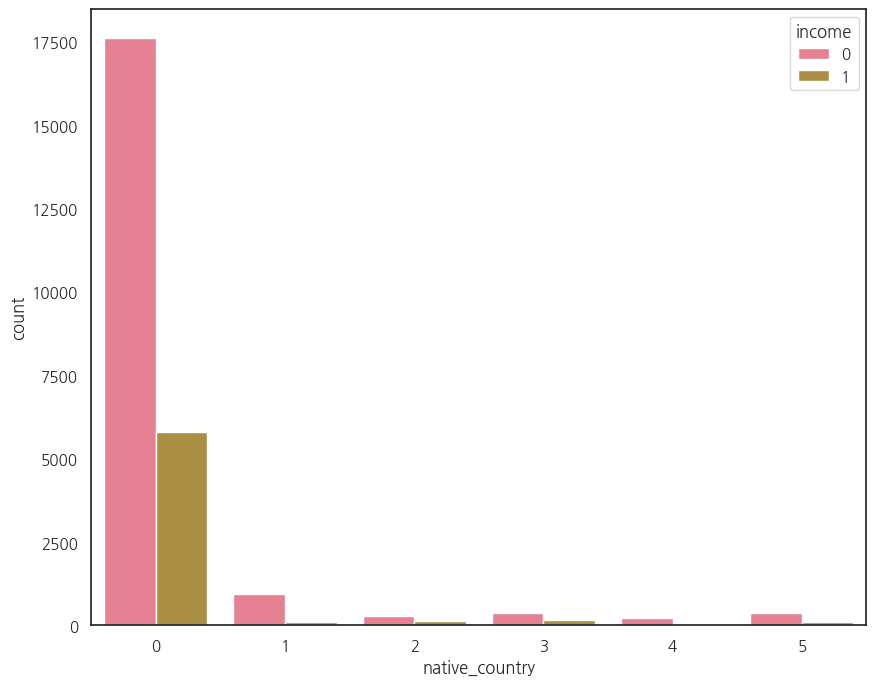

In [177]:
plt.rc("figure", figsize = (10, 8))

sns.countplot(x='native_country', hue='income', data=train, palette = colors)

### 3.7 Sex(성별)

별 다른 특이사항은 발견되지 않아 그대로 대략적 분포만 체크를 진행하였습니다.

In [178]:
train['sex'].value_counts()

sex
Male      17477
Female     8566
Name: count, dtype: int64

<Axes: xlabel='sex', ylabel='count'>

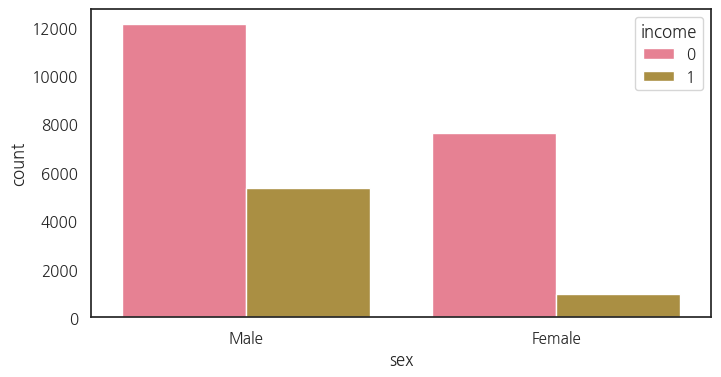

In [179]:
plt.rc("figure", figsize = (8, 4))

sns.countplot(x='sex', hue='income', data=train, palette = colors)

### 3.8 Hours_per_week(주당 근무 시간)

In [180]:
train['hours_per_week'].value_counts()

hours_per_week
40    12152
50     2314
45     1458
60     1164
35     1041
      ...  
81        1
92        1
89        1
88        1
94        1
Name: count, Length: 93, dtype: int64

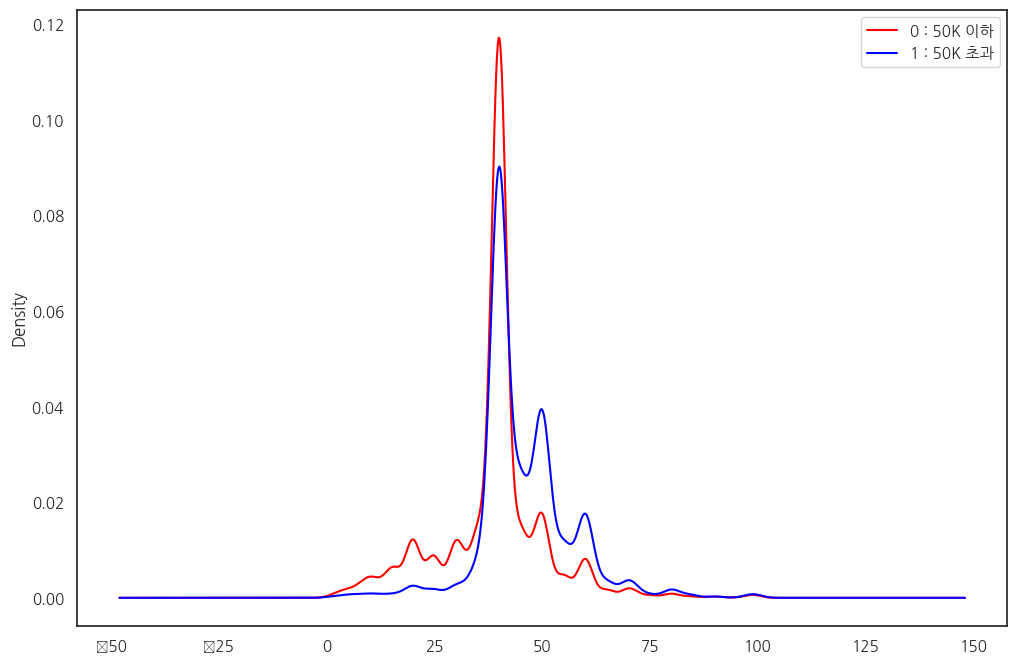

In [181]:
plt.rc("figure", figsize = (12, 8))

train[train['income'] == 0]['hours_per_week'].plot(kind='kde', color='red')
train[train['income'] == 1]['hours_per_week'].plot(kind='kde', color='blue')

plt.legend(labels=["0 : 50K 이하","1 : 50K 초과" ])

### 3.9 capital_gain(양도 소득) & capital_loss(양도 손실)

양도소득과 양도손실의 개념을 정의합니다.
<br /><br />
**capital_gain(양도 소득)**

개인이 토지, 건물 등 부동산이나 주식 등과 파생상품의 양도 또는 분양권과 같은

부동산에 관한 권리를 양도함으로 인하여 발생하는 이익(소득)을 과세대상으로 하여 부과하는 세금
<br /><br />
**capital_loss(양도 손실)**

투자 또는 부동산과 같은 자본 자산의 가치가 감소할 때 발생하는 손실

각 칼럼의 분포 값을 확인해보니 0값의 비율이 대부분을 차지하였다.

**capital_gain(양도 소득)**

In [182]:
print(train['capital_gain'].value_counts())

capital_gain
0        23850
15024      283
7688       229
7298       205
99999      127
         ...  
7978         1
6097         1
4931         1
22040        1
1455         1
Name: count, Length: 119, dtype: int64


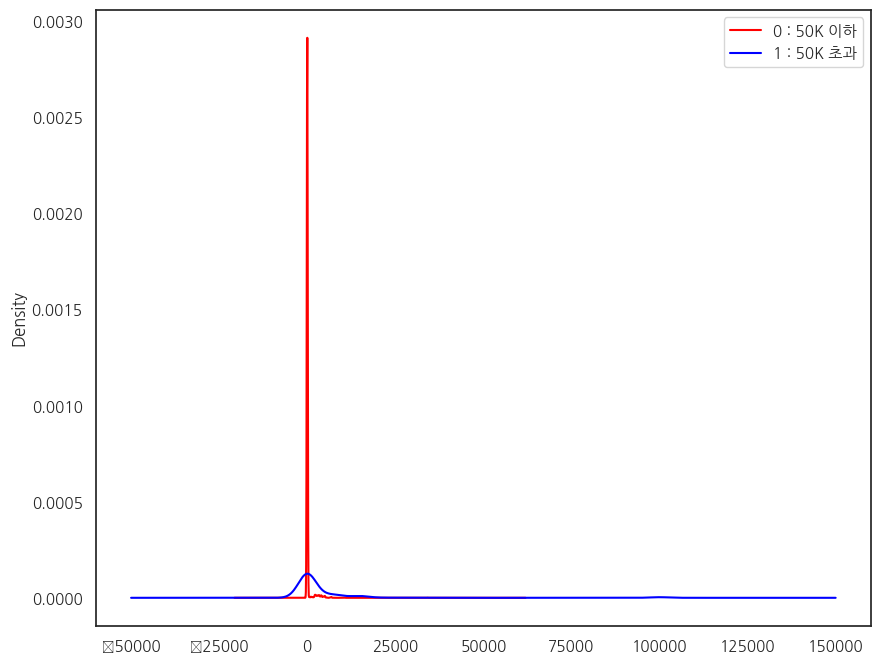

In [183]:
plt.rc("figure", figsize = (10, 8))

train[train['income'] == 0]['capital_gain'].plot(kind='kde', color='red')
train[train['income'] == 1]['capital_gain'].plot(kind='kde', color='blue')

plt.legend(labels=["0 : 50K 이하","1 : 50K 초과" ])

**capital_loss(양도 손실)**

In [184]:
print(train['capital_loss'].value_counts())

capital_loss
0       24817
1902      168
1977      136
1887      129
1602       41
        ...  
1816        1
2163        1
2467        1
323         1
2080        1
Name: count, Length: 90, dtype: int64


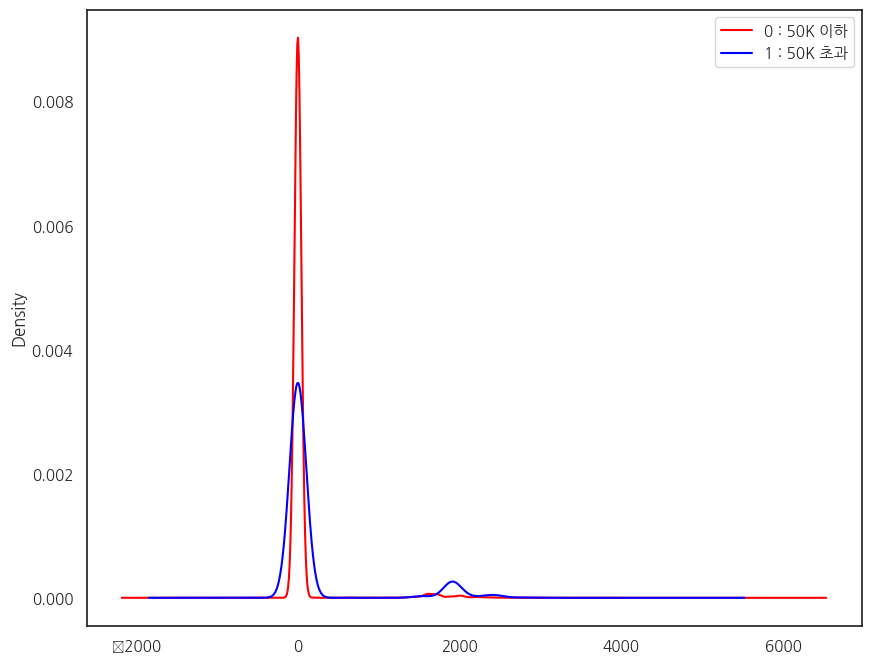

In [185]:
plt.rc("figure", figsize = (10, 8))

train[train['income'] == 0]['capital_loss'].plot(kind='kde', color='red')
train[train['income'] == 1]['capital_loss'].plot(kind='kde', color='blue')

plt.legend(labels=["0 : 50K 이하","1 : 50K 초과" ])

### 3.10 fnlwgt(사람 대표성 가중치)

fnlwgt는 전체 변수에 따른 가중치를 뜻합니다.

즉, 사람의 특성(결혼 유무, 학력)에 대한 대표성이 높을수록 fnlwgt는 높게 측정됩니다.


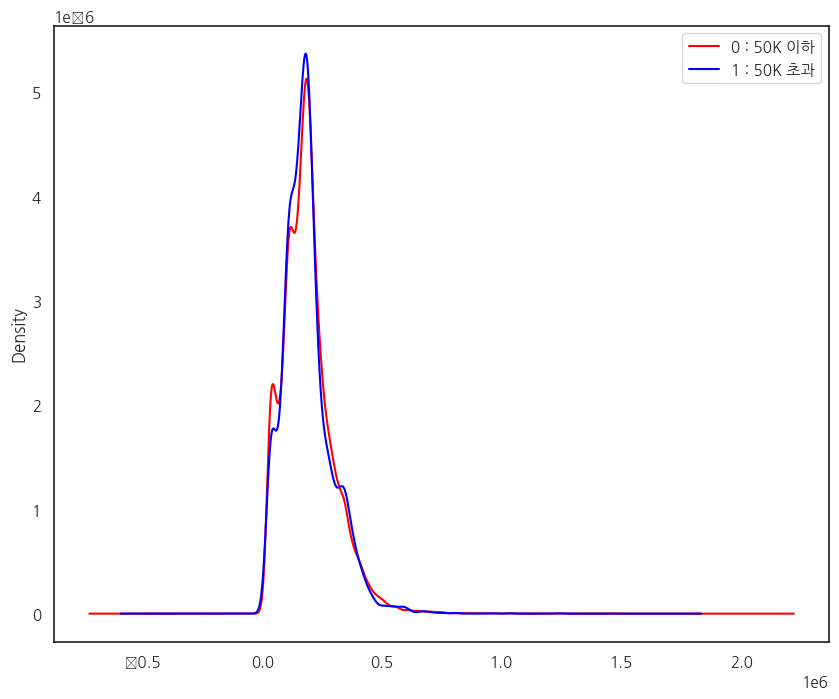

In [186]:
train[train['income'] == 0]['fnlwgt'].plot(kind='kde', color='red')
train[train['income'] == 1]['fnlwgt'].plot(kind='kde', color='blue')

plt.legend(labels=["0 : 50K 이하","1 : 50K 초과" ])

**[ Feature Engineering 적용사항]**

<br/>

- Target 예측값인 income 칼럼이 이진분류 가능한 값으로 해당 값을 0,1 값으로 반환
- Occupation(업종) : Never-worked 칼럼 "?" 6개 값을 Drop
- Native_country : 국가 별 5개 대륙으로 그룹화
  -  'United-States' : 0,
  - 'North America': 1,
  - 'Europe': 2,
  - 'Asia': 3,
  - 'South America': 4
  - '?' : 5

- education_num (교육 수준 수치) 칼럼을 Drop


## 4. train / test Data 동기화

### 4.1 함수화

In [187]:
# Feature Engineering 이후 분리할 인덱스
idx = len(train)

# train과 test set 합쳐서 한번에 진행

train = train_raw.copy()
test = test_raw.copy()

mix_data = pd.concat([train, test])

In [188]:
# 총 3개의 작업 수행

def preprocess_data(df):
    # Map 'income' column to binary values
    df['income'] = df['income'].map(lambda x: 1 if x == '>50K' else 0)

    # Drop 'Never-worked' rows from 'workclass' column
    df.drop(df[df['workclass'] == 'Never-worked'].index, axis=0, inplace=True)

    # Define native country mappings
    united_states = ['United-States']
    north_america = ['Mexico', 'Canada', 'Puerto-Rico', 'El-Salvador', 'Cuba', 'Jamaica', 'Guatemala', 'Dominican-Republic', 'Honduras']
    europe = ['Germany', 'England', 'Italy', 'Poland', 'Portugal', 'Greece', 'Ireland', 'Scotland', 'France', 'Yugoslavia', 'Hungary']
    asia = ['Philippines', 'India', 'China', 'Japan', 'Taiwan', 'Iran', 'Vietnam', 'Hong', 'Cambodia', 'Laos', 'Thailand']
    south_america = ['South', 'Columbia', 'Peru', 'Ecuador', 'Haiti', 'Trinadad&Tobago', 'Nicaragua', 'Outlying-US(Guam-USVI-etc)']

    native_country_dict = {}

    for country in united_states:
        native_country_dict[country] = 'United-States'

    for country in north_america:
        native_country_dict[country] = 'North America'

    for country in europe:
        native_country_dict[country] = 'Europe'

    for country in asia:
        native_country_dict[country] = 'Asia'

    for country in south_america:
        native_country_dict[country] = 'South America'

    # Define continent encoding
    continent_encoding = {
        'United-States' : 0,
        'North America': 1,
        'Europe': 2,
        'Asia': 3,
        'South America': 4
    }

    # Map 'native_country' column to continent names and encode
    df['native_country'] = df['native_country'].map(lambda x: continent_encoding.get(native_country_dict.get(x, '?'), 5))

    # Drop 'education_num' column
    df.drop('education_num', axis=1, inplace=True)

    return df

mix_data = preprocess_data(mix_data)

In [189]:
mix_data.head()

,id,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,0,40,Private,168538,HS-grad,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,0,1
1,1,17,Private,101626,9th,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,20,0,0
2,2,18,Private,353358,Some-college,Never-married,Other-service,Own-child,White,Male,0,0,16,0,0
3,3,21,Private,151158,Some-college,Never-married,Prof-specialty,Own-child,White,Female,0,0,25,0,0
4,4,24,Private,122234,Some-college,Never-married,Adm-clerical,Not-in-family,Black,Female,0,0,20,5,0


### 4.2 추가적인 불필요한 데이터 Drop

In [190]:
drop_col = ['id',"sex", "native_country", "race", "fnlwgt"]

mix_data = mix_data.drop(columns=drop_col)

In [191]:
mix_data.head()

,age,workclass,education,marital_status,occupation,relationship,capital_gain,capital_loss,hours_per_week,income
0,40,Private,HS-grad,Married-civ-spouse,Sales,Husband,0,0,60,1
1,17,Private,9th,Never-married,Machine-op-inspct,Own-child,0,0,20,0
2,18,Private,Some-college,Never-married,Other-service,Own-child,0,0,16,0
3,21,Private,Some-college,Never-married,Prof-specialty,Own-child,0,0,25,0
4,24,Private,Some-college,Never-married,Adm-clerical,Not-in-family,0,0,20,0


### 4.3 Lable Encoding

In [192]:
from sklearn.preprocessing import LabelEncoder

label_col = [col for col in mix_data.columns if mix_data[col].dtypes == 'object' and col != 'income']

le = LabelEncoder()

for col in label_col:
    mix_data[col] = le.fit_transform(mix_data[col])

In [193]:
mix_data.head()

,age,workclass,education,marital_status,occupation,relationship,capital_gain,capital_loss,hours_per_week,income
0,40,3,11,2,12,0,0,0,60,1
1,17,3,6,4,7,3,0,0,20,0
2,18,3,15,4,8,3,0,0,16,0
3,21,3,15,4,10,3,0,0,25,0
4,24,3,15,4,1,1,0,0,20,0


### 4.4 Train / Test 데이터셋 분할

idx는 데이터셋에서 학습 데이터와 테스트 데이터를 나누는

경계선을 나타내는 인덱스로 해당 기준으로 train / test 데이터셋을 분할합니다.

In [196]:
train_data= mix_data.iloc[:idx, :]
test_data = mix_data.iloc[idx:, :].drop('income', axis=1)

print(train_data.shape)
print(test_data.shape)

(26043, 10)
(6510, 9)


In [197]:
from sklearn.model_selection import train_test_split

seed = 2024

# train_data 에서 Target 값 분할
X = train_data.drop('income', axis=1)
y = train_data['income']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=seed)

print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(19532, 9)
(6511, 9)
(19532,)
(6511,)


## 5. Modeling

In [198]:
# 스코어 확인 함수
# python ML Guide 참고

from sklearn.metrics import f1_score
from sklearn.metrics import *

def get_clf_eval(y_test, pred=None, pred_proba=None):

    # 오차 행렬
    confusion = confusion_matrix(y_test, pred)

    # 정확도
    accuracy = accuracy_score(y_test, pred)

    # 정밀도
    precision = precision_score(y_test, pred)

    # 재현율
    recall = recall_score(y_test, pred)

    # F1 score
    f1 = f1_score(y_test, pred)

    # ROC AUC score
    roc_auc = roc_auc_score(y_test, pred_proba) if pred_proba is not None else None

    # 계산된 지표 반환
    return confusion, accuracy, precision, recall, f1, roc_auc

    print('오차 행렬')
    print(confusion)
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}')

## 6. Muchin Learning Model

머신러닝 모델 중 default hyperparameters로 학습 후 score 측정합니다.

이후 더 나은 모델에 대한 GridSearchCV 적용 및 그 후에 Stacking 적용합니다.

In [199]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

### 6.1 Random Forest

In [200]:
rf = RandomForestClassifier(n_jobs=-1, random_state=seed)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_valid) # 예측값
y_pred_percent = rf.predict_proba(X_valid) # 예측 확률

rf_score = f1_score(y_valid, y_pred)
print("RF 기본 성능 확인 스코어: {:.4f}".format(rf_score))

RF 기본 성능 확인 스코어: 0.6629


In [201]:
get_clf_eval(y_valid, y_pred, y_pred_percent[:, 1])

(array([[4522,  403],
        [ 600,  986]]),
 0.8459530026109661,
 0.7098632109431245,
 0.6216897856242118,
 0.6628571428571428,
 0.8929406417831148)

### 6.2 LightGBM

In [202]:
lgbm = LGBMClassifier(n_jobs=-1, random_state=seed)

lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_valid) # 예측값
y_pred_lgbm_percent = lgbm.predict_proba(X_valid)[:, 1] # 예측 확률

get_clf_eval(y_valid, y_pred_lgbm, y_pred_lgbm_percent)

[LightGBM] [Info] Number of positive: 4719, number of negative: 14813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 360
[LightGBM] [Info] Number of data points in the train set: 19532, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.241604 -> initscore=-1.143908
[LightGBM] [Info] Start training from score -1.143908


(array([[4648,  277],
        [ 566, 1020]]),
 0.8705268007986484,
 0.7864302235929067,
 0.6431273644388399,
 0.7075962539021853,
 0.9264391471057027)

### 6.3 CatBoost

In [203]:
cb = CatBoostClassifier(random_seed=seed, verbose=0)

cb.fit(X_train, y_train)
y_pred_cb = cb.predict(X_valid) # 예측값
y_pred_cb_percent = cb.predict_proba(X_valid)[:, 1] # 예측 확률

get_clf_eval(y_valid, y_pred_cb, y_pred_cb_percent)

(array([[4652,  273],
        [ 568, 1018]]),
 0.8708339732759944,
 0.7885360185902401,
 0.6418663303909206,
 0.7076816127911018,
 0.9264100217000275)

### 6.4 Best Model

LGBM 모델이 가장 높은 성능을 보여 GridSearchCV를 활용해 하이퍼 파라미터 튜닝을 진행한다.

In [204]:
from sklearn.model_selection import GridSearchCV

lgbm = LGBMClassifier(random_state=seed)

# 탐색할 하이퍼파라미터 설정을 params 딕셔너리에서 정의
params = {
    'boosting_type': ['gbdt', 'dart'], # defalt = 'gbdt'
    'num_leaves': [20, 31, 50, 70], # default = 31
    'max_depth': [-1, 5, 7, 10, 15, 20, 30], # default = -1 (끝까지 깊게 확장 설정)
    'learning_rate': [0.001, 0.01, 0.05, 0.1], # defaut = 0.1
}

lgbm_grid_cv = GridSearchCV(lgbm, param_grid=params, scoring='f1', n_jobs=-1, cv=5, verbose=1)
lgbm_grid_cv.fit(X, y)

Fitting 5 folds for each of 224 candidates, totalling 1120 fits
[LightGBM] [Info] Number of positive: 6305, number of negative: 19738
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 26043, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.242100 -> initscore=-1.141203
[LightGBM] [Info] Start training from score -1.141203


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=2024), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt', 'dart'],
                         'learning_rate': [0.001, 0.01, 0.05, 0.1],
                         'max_depth': [-1, 5, 7, 10, 15, 20, 30],
                         'num_leaves': [20, 31, 50, 70]},
             scoring='f1', verbose=1)

In [205]:
print('GridSearchCV 최고 평균 정확도 : {:.4f}'.format(lgbm_grid_cv.best_score_))
print('GridSearchCv 최적 하이퍼 파라미터: ', lgbm_grid_cv.best_params_)

GridSearchCV 최고 평균 정확도 : 0.7156
GridSearchCv 최적 하이퍼 파라미터:  {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': -1, 'num_leaves': 31}


## 7. Feature 중요도 시각화

In [206]:
best_lgbm = lgbm_grid_cv.best_estimator_
lgbm_pred = best_lgbm.predict(test_data)

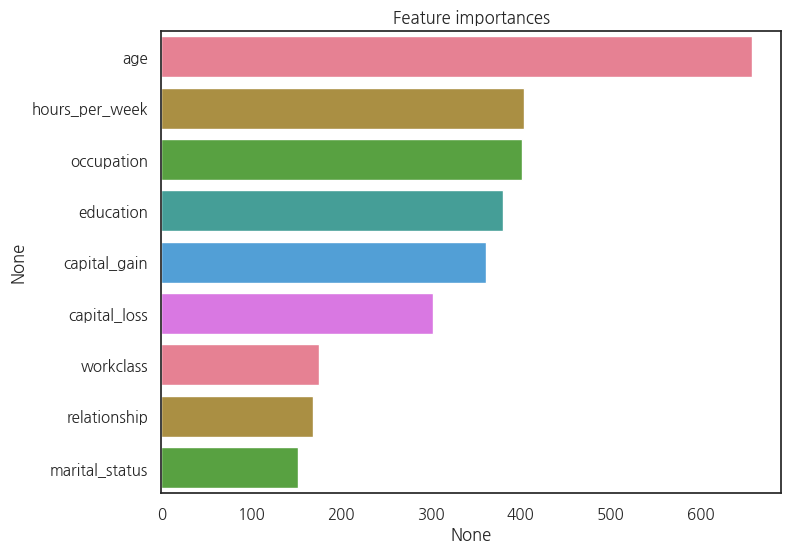

In [208]:
ftr_importances_values = best_lgbm.feature_importances_

# Top 중요도로 정렬을 쉽게 하고, Seaborn의 막대그래프로 쉽게 표현하기 위해 Series 변환
ftr_importances = pd.Series(ftr_importances_values, index=X.columns)

# 중요도 값 순으로 Series를 정렬
ftr_top = ftr_importances.sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=ftr_top, y=ftr_top.index, orient='h', palette = colors)
plt.title('Feature importances')
plt.show()